Mounting Google Drive

In [ ]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import sys
sys.path.insert(0,'/content/drive/MyDrive /Colab Notebooks/Session 7')

In [ ]:

pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importing libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
%matplotlib inline

Updating Device to CUDA

In [ ]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if cuda else "cpu") #c2

CUDA Available? True


Importing custom modules

In [ ]:
import utils
import model

In [ ]:
from utils import   (
 plot_graphs,
 plots,
 plt,
 torch,
 tqdm
 )

In [ ]:
from model import (F,
  Net6, Net8, Net9, nn, torch)

Defining data tranformations

In [ ]:
train_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-10., 10.), fill=1),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])


Downloading MNIST dataset and splitting to train and test set

In [ ]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

Creating Data Loaders from train data and test data

In [ ]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

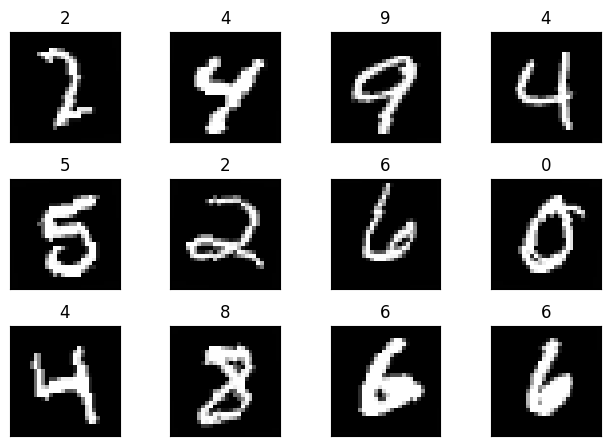

In [ ]:
plots(train_loader)

## Data Statistics

torch.Size([512, 1, 28, 28])
torch.Size([512])


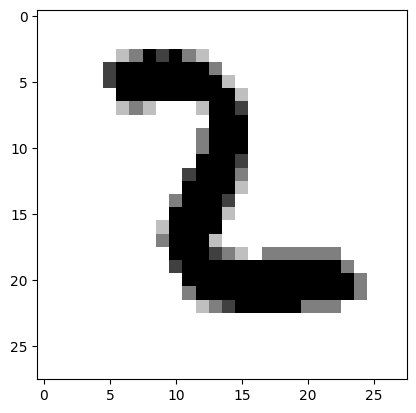

In [ ]:
# train_data1 = train_data.train_data
# train_data = train_data.transform(train_data1.numpy())

# print('[Train]')
# print(' - Numpy Shape:', train_data.train_data.cpu().numpy().shape)
# print(' - Tensor Shape:', train_data.train_data.size())
# print(' - min:', torch.min(train_data))
# print(' - max:', torch.max(train_data))
# print(' - mean:', torch.mean(train_data))
# print(' - std:', torch.std(train_data))
# print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

Viewing images

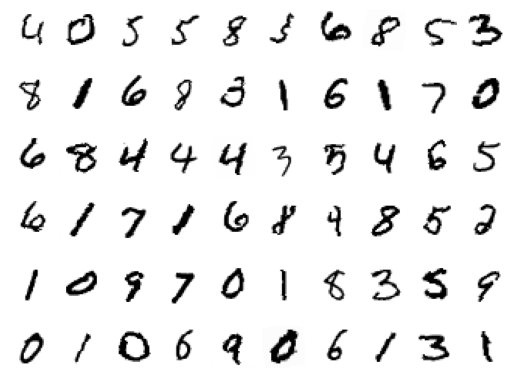

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

Transferring model to GPU and printing model summary

In [ ]:
model1 = Net9().to(device)
summary(model1, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 15, 24, 24]           1,350
              ReLU-6           [-1, 15, 24, 24]               0
       BatchNorm2d-7           [-1, 15, 24, 24]              30
           Dropout-8           [-1, 15, 24, 24]               0
         MaxPool2d-9           [-1, 15, 12, 12]               0
           Conv2d-10           [-1, 16, 10, 10]           2,160
             ReLU-11           [-1, 16, 10, 10]               0
      BatchNorm2d-12           [-1, 16, 10, 10]              32
          Dropout-13           [-1, 16, 10, 10]               0
           Conv2d-14           [-1, 10,

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

Training and evaluating the model

In [ ]:
model =  Net9().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.20, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.10)
#scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10, threshold=0.0001, threshold_mode='abs')
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch + 1)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 1


Loss=0.20322264730930328 Batch_id=117 Accuracy=86.62: 100%|██████████| 118/118 [00:44<00:00,  2.63it/s]



Test set: Average loss: 0.0888, Accuracy: 9724/10000 (97.24%)

EPOCH: 2


Loss=0.11057814955711365 Batch_id=117 Accuracy=97.36: 100%|██████████| 118/118 [00:43<00:00,  2.73it/s]



Test set: Average loss: 0.0776, Accuracy: 9755/10000 (97.55%)

EPOCH: 3


Loss=0.04322466626763344 Batch_id=117 Accuracy=97.76: 100%|██████████| 118/118 [00:44<00:00,  2.64it/s]



Test set: Average loss: 0.0344, Accuracy: 9904/10000 (99.04%)

EPOCH: 4


Loss=0.11243569850921631 Batch_id=117 Accuracy=98.29: 100%|██████████| 118/118 [00:48<00:00,  2.43it/s]



Test set: Average loss: 0.0323, Accuracy: 9903/10000 (99.03%)

EPOCH: 5


Loss=0.022237062454223633 Batch_id=117 Accuracy=98.32: 100%|██████████| 118/118 [00:48<00:00,  2.42it/s]



Test set: Average loss: 0.0300, Accuracy: 9900/10000 (99.00%)

EPOCH: 6


Loss=0.09765539318323135 Batch_id=117 Accuracy=98.53: 100%|██████████| 118/118 [00:45<00:00,  2.61it/s]



Test set: Average loss: 0.0325, Accuracy: 9902/10000 (99.02%)

EPOCH: 7


Loss=0.03121902234852314 Batch_id=117 Accuracy=98.84: 100%|██████████| 118/118 [00:44<00:00,  2.63it/s]



Test set: Average loss: 0.0242, Accuracy: 9927/10000 (99.27%)

EPOCH: 8


Loss=0.02062111720442772 Batch_id=117 Accuracy=98.90: 100%|██████████| 118/118 [00:44<00:00,  2.64it/s]



Test set: Average loss: 0.0224, Accuracy: 9927/10000 (99.27%)

EPOCH: 9


Loss=0.02562001906335354 Batch_id=117 Accuracy=98.97: 100%|██████████| 118/118 [00:47<00:00,  2.47it/s]



Test set: Average loss: 0.0222, Accuracy: 9930/10000 (99.30%)

EPOCH: 10


Loss=0.020520804449915886 Batch_id=117 Accuracy=98.94: 100%|██████████| 118/118 [00:45<00:00,  2.60it/s]



Test set: Average loss: 0.0217, Accuracy: 9935/10000 (99.35%)

EPOCH: 11


Loss=0.09382113814353943 Batch_id=117 Accuracy=98.97: 100%|██████████| 118/118 [00:43<00:00,  2.70it/s]



Test set: Average loss: 0.0219, Accuracy: 9934/10000 (99.34%)

EPOCH: 12


Loss=0.08171296864748001 Batch_id=117 Accuracy=99.02: 100%|██████████| 118/118 [00:39<00:00,  3.00it/s]



Test set: Average loss: 0.0210, Accuracy: 9942/10000 (99.42%)

EPOCH: 13


Loss=0.00664951466023922 Batch_id=117 Accuracy=99.01: 100%|██████████| 118/118 [00:42<00:00,  2.80it/s]



Test set: Average loss: 0.0211, Accuracy: 9940/10000 (99.40%)

EPOCH: 14


Loss=0.007530474569648504 Batch_id=117 Accuracy=99.02: 100%|██████████| 118/118 [00:41<00:00,  2.83it/s]



Test set: Average loss: 0.0213, Accuracy: 9937/10000 (99.37%)

EPOCH: 15


Loss=0.0014802514342591166 Batch_id=117 Accuracy=98.95: 100%|██████████| 118/118 [00:39<00:00,  2.98it/s]



Test set: Average loss: 0.0210, Accuracy: 9938/10000 (99.38%)



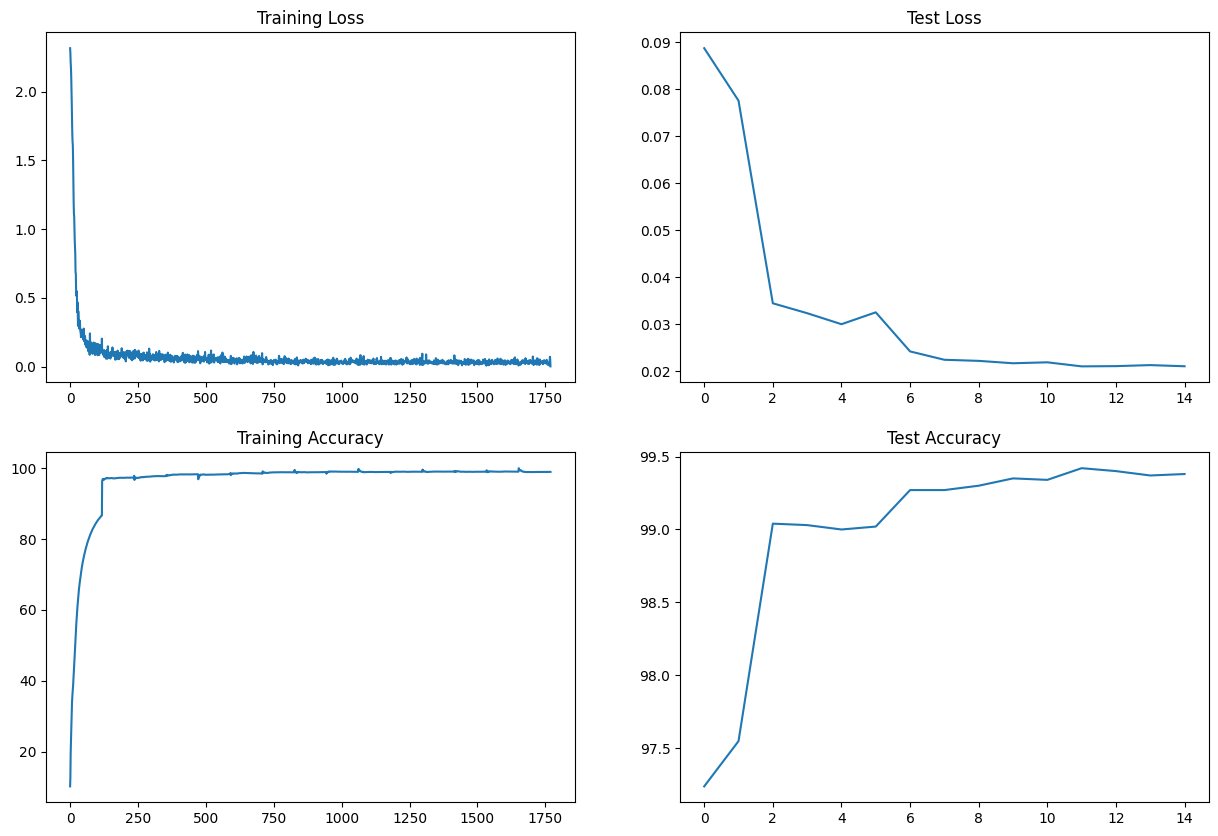

In [ ]:
train_losses = [t_items.item() for t_items in train_losses]
plot_graphs(train_losses, train_acc, test_losses ,test_acc)

# Target:

To achieve consistent 99.4% test accuracy

# Results:
Parameters: 7950

Best Training Accuracy: 99.02

Best Test Accuracy: 99.42

# Analysis:

Model is training well. Desired accuracy achieved from 12th epoch 
Learning rate started from 0.2 and stepped down at every 6th epoch